# Intro to 4D-STEM data: calibration

There are many calibrations that can be performed on 4DSTEM data.  Which ones are necessary depends on the data and the analysis being performed.  The most typical calibrations are

- the origin
- the ellipticity
- the pixel size

In this notebook we'll perform these three calibration.

There are various methods for performing calibrations.  Here we'll calibrate using the Bragg vectors detected in the previous notebook.


### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)


Updated 11/1/2023, version 0.14.8

## Set up the environment

In [69]:
import py4DSTEM
import time
import os
from py4DSTEM.visualize import show

timestr = time.strftime("%Y%m%d")
#timestr = '20240813' # in case you want to use older data/not preprocess everything again

py4DSTEM.__version__

'0.14.15'

# Load data

Load
- the same datacube as in the previous notebook, and 
- the results from basics_02 (disk detection)

In [154]:
# Load the .dm4 file from a workspace on OMNI or XNAS, set filepath with 'filepath_data = "FILEPATH"'
# even better, use dirpath'' and 'filepath_data', this makes it easier to add more paths later

dirpath = "/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/"

filepath_data = dirpath + 'COPL_Ni65Cu35_C_ROI3_240827_aper_50_conv_1.5_spot_6_CL_47_stepsize_10_r_x_178_r_y_186_GIF_512x512_preprocessed_unfiltered_no_bin.h5'
filepath_basics_01 = dirpath + 'analysis_basics_01.h5'
filepath_basics_02 = dirpath + 'analysis_basics_02.h5'

In [155]:
# Load the datacube

datacube = py4DSTEM.read(
    filepath = filepath_data,
    datapath = 'dm_dataset_root/dm_dataset'
)

datacube

DataCube( A 4-dimensional array of shape (186, 178, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0,5,10,...] nm
              Ry = [0,5,10,...] nm
              Qx = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
              Qy = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
)

In [156]:
# Load the prior analysis

basics_02 = py4DSTEM.read(
    filepath_basics_02
)

basics_02.tree()

Reading PointListArray: 100%|████████████████████████████| 33108/33108 [00:05<00:00, 6311.28PointList/s]

/
|---braggvectors
|---probe


# Examine the Bragg vectors

In [163]:
# Let's assign the bragg vectors a variable for convenience

braggpeaks = basics_02.tree('braggvectors')
braggpeaks

BraggVectors( A (186, 178)-shaped array of lists of bragg vectors )

In [164]:
# Data can be retrieved from BraggVectors instances in two places: .raw, and .cal
# Let's look at .raw first:

braggpeaks.raw

RawVectorGetter( Retrieves raw bragg vectors. Get vectors for scan position x,y with [x,y]. )

In [165]:
braggpeaks.raw[0,0]

BVects( A set of 30 bragg vectors. Access data with .qx, .qy, .I, or .data. Optionally .h, .k, and.l, if indexed)

In [166]:
print(braggpeaks.raw[0,0].qx)
print()
print(braggpeaks.raw[0,0].qy)
print()
print(braggpeaks.raw[0,0].I)

[254.05525354 167.06376072 135.52030709 414.54708877 398.45762563
 362.17850468 296.72274748  48.3227012  371.21983554 326.34466439
 311.24649461 210.92115185 363.18837997 295.25528685 295.05016232
 289.42948415 211.68355214 177.76489324 266.15789338 243.84288284
 285.74619178 324.59440828 305.98641787 255.37048538 283.83023177
 243.02604197 239.21731752 211.5708227  437.75819588 198.09819548]

[252.31174372 416.42386686 269.91923213 101.96847134 414.63036301
 342.12440354 119.20683794 434.19128303 234.75403167 267.33817914
  65.75826202 283.2120825  104.96608699 215.50219571 255.32596019
 236.91636428 382.31350899 135.37922729 180.76633303 359.41543448
 274.76650031 300.58398451 295.86162761 206.36140873 398.05243822
 324.04138977 194.08091968 208.28872216 200.3519498  226.51919511]

[77094.9675459  18712.69948111  9770.74310096  6572.3630711
  4382.146491    2627.24028915  2416.59489087  2191.81971423
  2161.88605469  1970.8193869   1151.10236342  1037.82961684
   928.35116      921.

In [167]:
# The .data property gives us everything (positions and intensities) in a single numpy array.
# It's a structured array, meaning it has a 'dtype' containing several fields,
# each with their own datatype

braggpeaks.raw[0,0].data

array([(254.05525354, 252.31174372, 77094.9675459 ),
       (167.06376072, 416.42386686, 18712.69948111),
       (135.52030709, 269.91923213,  9770.74310096),
       (414.54708877, 101.96847134,  6572.3630711 ),
       (398.45762563, 414.63036301,  4382.146491  ),
       (362.17850468, 342.12440354,  2627.24028915),
       (296.72274748, 119.20683794,  2416.59489087),
       ( 48.3227012 , 434.19128303,  2191.81971423),
       (371.21983554, 234.75403167,  2161.88605469),
       (326.34466439, 267.33817914,  1970.8193869 ),
       (311.24649461,  65.75826202,  1151.10236342),
       (210.92115185, 283.2120825 ,  1037.82961684),
       (363.18837997, 104.96608699,   928.35116   ),
       (295.25528685, 215.50219571,   921.56715345),
       (295.05016232, 255.32596019,   906.74375507),
       (289.42948415, 236.91636428,   861.92750001),
       (211.68355214, 382.31350899,   814.06338732),
       (177.76489324, 135.37922729,   811.81209518),
       (266.15789338, 180.76633303,   779.2617

In [168]:
braggpeaks.raw[0,0].data['qx']

array([254.05525354, 167.06376072, 135.52030709, 414.54708877,
       398.45762563, 362.17850468, 296.72274748,  48.3227012 ,
       371.21983554, 326.34466439, 311.24649461, 210.92115185,
       363.18837997, 295.25528685, 295.05016232, 289.42948415,
       211.68355214, 177.76489324, 266.15789338, 243.84288284,
       285.74619178, 324.59440828, 305.98641787, 255.37048538,
       283.83023177, 243.02604197, 239.21731752, 211.5708227 ,
       437.75819588, 198.09819548])

In [169]:
# The calibrated vectors at .cal have the same interface
# The only difference is that these vectors are transformed before
# being returned, where the transformation is determined
# by the BraggVector's calibration state

braggpeaks.cal

CalibratedVectorGetter( Retrieves calibrated Bragg vectors. Get vectors for scan position x,y with [x,y].
                        Set which calibrations to apply with braggvectors.setcal(...). )

In [170]:
# We haven't made any calibration measurements yet, and none
# were retrieved from microscopy metadata (like pixel sizes),
# so currently no calibrations are applied and the .cal and
# .raw vectors are identical.

braggpeaks.cal[0,0].data

array([(254.05525354, 252.31174372, 77094.9675459 ),
       (167.06376072, 416.42386686, 18712.69948111),
       (135.52030709, 269.91923213,  9770.74310096),
       (414.54708877, 101.96847134,  6572.3630711 ),
       (398.45762563, 414.63036301,  4382.146491  ),
       (362.17850468, 342.12440354,  2627.24028915),
       (296.72274748, 119.20683794,  2416.59489087),
       ( 48.3227012 , 434.19128303,  2191.81971423),
       (371.21983554, 234.75403167,  2161.88605469),
       (326.34466439, 267.33817914,  1970.8193869 ),
       (311.24649461,  65.75826202,  1151.10236342),
       (210.92115185, 283.2120825 ,  1037.82961684),
       (363.18837997, 104.96608699,   928.35116   ),
       (295.25528685, 215.50219571,   921.56715345),
       (295.05016232, 255.32596019,   906.74375507),
       (289.42948415, 236.91636428,   861.92750001),
       (211.68355214, 382.31350899,   814.06338732),
       (177.76489324, 135.37922729,   811.81209518),
       (266.15789338, 180.76633303,   779.2617

In [171]:
# You can check the current calibration state

braggpeaks.calstate

{'center': False, 'ellipse': False, 'pixel': False, 'rotate': False}

In [172]:
# The calibration state should update automatically as new calibrations measurements
# are taken.  You can also override these and set which calibrations you want applied
# when .cal is used with the .setcal method

braggpeaks.setcal?

Signature: braggpeaks.setcal(center=None, ellipse=None, pixel=None, rotate=None)
Docstring:
Calling

    >>> braggvectors.setcal(
    >>>     center = bool,
    >>>     ellipse = bool,
    >>>     pixel = bool,
    >>>     rotate = bool,
    >>> )

sets the calibrations that will be applied to vectors subsequently
retrieved with

    >>> braggvectors.cal[ scan_x, scan_y ]

Any arguments left as `None` will be automatically set based on
the calibration measurements available.
File:      ~/.conda/envs/py4dstem/lib/python3.10/site-packages/py4DSTEM/braggvectors/braggvectors.py
Type:      method

In [173]:
# Calling .setcal method with no arguments are supplied sets the calibration state
# based on what's available in the dataset's Calibration metadata (i.e. at .calibation)

braggpeaks.setcal()

In [174]:
# All the calibrations are still set to False because we haven't performed
# any calibration measurements yet!

braggpeaks.calstate

{'center': False, 'ellipse': False, 'pixel': True, 'rotate': False}

In [175]:
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.0072991721332073215
             R_pixel_size:      5
             Q_pixel_units:     A^-1
             R_pixel_units:     nm
             QR_flip:           False
             _root_treepath:    
             probe_semiangle:   9.379479520193339
             qx0_mean:          254.1587822612376
             qy0_mean:          252.3177333351497
)

In [176]:
# If we try to set the braggvector's calibration state to perform a transformation
# for which is can't find the needed measurement in the Calibration metadata, it
# raises an error

# braggpeaks.setcal(
#    center = True,       # This can't be True without first setting the origin position!
#    ellipse = False,
#    pixel = False,
#    rotate = False
#)

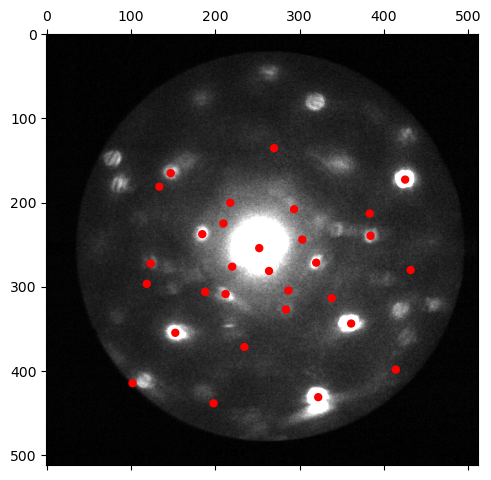

In [177]:
# Let's confirm that the raw vectors represent the positions of
# detected bragg disks in a sample diffraction pattern

dp = datacube[60,75]
v = braggpeaks.raw[60,75]

show(
    dp,
    points = {
        'x' : v.qx,
        'y' : v.qy,
    }
)

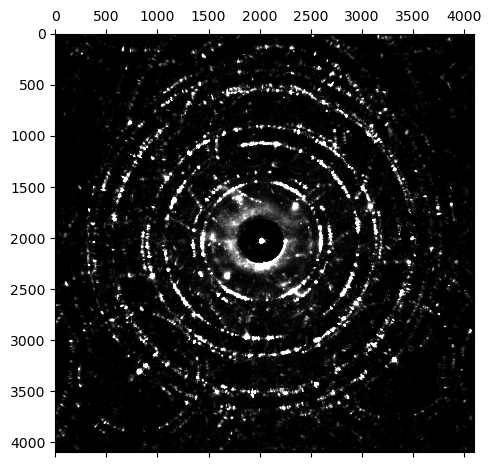

In [178]:
# compute the bragg vector map

bvm = braggpeaks.histogram(
    mode='raw',
    sampling = 8,
)

show(bvm)

In [179]:
# The bragg vector map is another py4DSTEM class which contains various self-descriptive metadata items

bvm

BraggVectorMap( A 2-dimensional array of shape (4096, 4096) called '2Dhist_braggvectors_raw_s=8',
                with dimensions:

                    dim0 = [0.0,0.125,0.25,...] A^-1
                    dim1 = [0.0,0.125,0.25,...] A^-1
)

In [180]:
print(bvm.origin)
print(bvm.pixelsize)
print(bvm.pixelunits)

(0, 0)
0.125
A^-1


In [181]:
bvm.dims[0]

array([0.00000e+00, 1.25000e-01, 2.50000e-01, ..., 5.11625e+02,
       5.11750e+02, 5.11875e+02])

# Calibrate the origin

We'll calibrate the origin in two steps:

- measure the origin position using the brightest disk from the disk detection
- fit a plane to those measurements

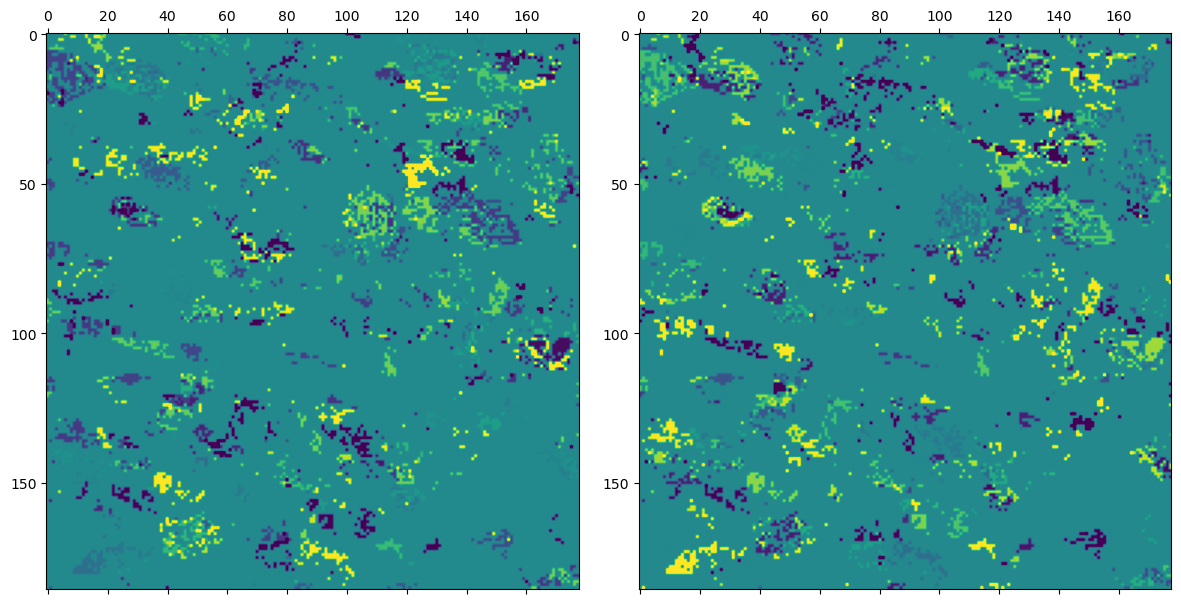

In [182]:
# Measure the origin

qx0_meas,qy0_meas,mask_meas = braggpeaks.measure_origin()

show(
    [qx0_meas,qy0_meas],
    cmap = 'viridis',
    mask = mask_meas
)

In [183]:
# Note that braggpeaks.measure_origin added its results to the Calibration metadata

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.0072991721332073215
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    9.379479520193339
             qx0_mean:           254.1587822612376
             qy0_mean:           252.3177333351497
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
)

In [184]:
# Here's how to retrieve the data:

braggpeaks.calibration.get_origin_meas()

(array([[254.05525354, 254.02736566, 254.01389167, ..., 253.89745551,
         254.25499186, 254.48728825],
        [254.19216198, 254.08918829, 254.09768601, ..., 254.581215  ,
         254.23041449, 254.24539564],
        [254.07002012, 254.13624644, 254.08426822, ..., 254.28955143,
         167.6023603 , 254.32739178],
        ...,
        [253.99768271, 253.96233198, 254.08795522, ..., 254.40638162,
         325.06822749, 325.96053714],
        [253.96507791, 254.0840468 , 254.1458504 , ..., 254.36929446,
         324.03317715, 254.30691727],
        [253.99094266, 211.07895212, 254.07203136, ..., 254.38817406,
         254.19731927, 254.09250645]]),
 array([[252.31174372, 252.40902272, 252.29044323, ..., 252.30744946,
         252.52674737, 253.13911995],
        [252.28063563, 252.34392068, 252.22717517, ..., 252.30233281,
         252.26536443, 252.42446472],
        [252.35060027, 252.32462656, 252.19561626, ..., 252.36395189,
         171.7045264 , 252.34506148],
        ...,


In [185]:
# These arrays are identical to the ones we just found

print( braggpeaks.calibration.get_origin_meas()[0] is qx0_meas )
print( braggpeaks.calibration.get_origin_meas()[1] is qy0_meas )

True
True


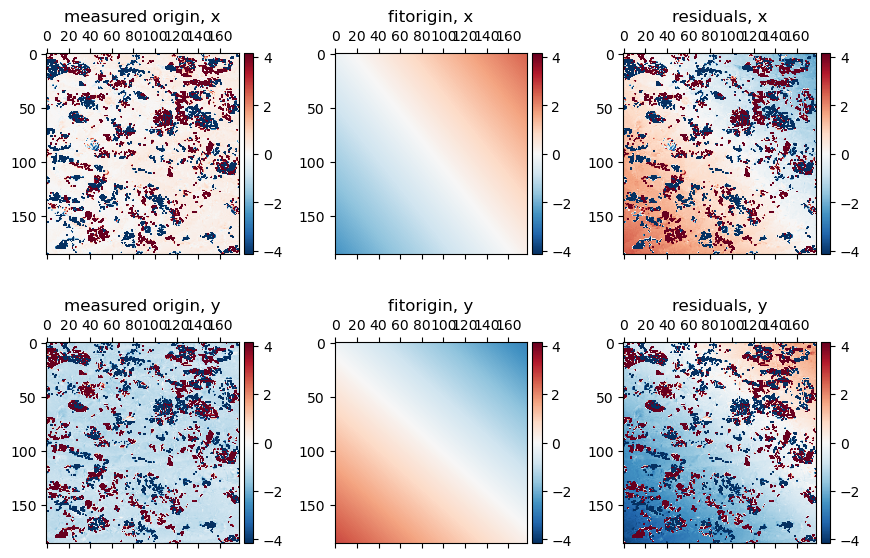

In [186]:
# Fit a plane to the origins

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin()

In [187]:
# The fit origins now live in the calibration metadata as 'qx0','qy0'

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.0072991721332073215
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    9.379479520193339
             qx0_mean:           253.9385904004459
             qy0_mean:           253.29710703002038
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_shift:          2D-array
)

In [188]:
# The calibration state of our BraggVectors has automatically updated

braggpeaks.calstate

{'center': True, 'ellipse': False, 'pixel': True, 'rotate': False}

In [189]:
# and calling .cal now gives us the centered vector positions

braggpeaks.cal[0,0].data

array([( 0.00250112, -0.00559604, 77094.9675459 ),
       (-0.63246476,  1.1922866 , 18712.69948111),
       (-0.86270586,  0.12292405,  9770.74310096),
       ( 1.17395865, -1.10297746,  6572.3630711 ),
       ( 1.05651889,  1.1791955 ,  4382.146491  ),
       ( 0.79171134,  0.64996203,  2627.24028915),
       ( 0.3139385 , -0.97715166,  2416.59489087),
       (-1.4991762 ,  1.32197403,  2191.81971423),
       ( 0.85770557, -0.1337528 ,  2161.88605469),
       ( 0.53015397,  0.1040845 ,  1970.8193869 ),
       ( 0.41994983, -1.36728201,  1151.10236342),
       (-0.31234212,  0.21995085,  1037.82961684),
       ( 0.79908259, -1.08109735,   928.35116   ),
       ( 0.30322725, -0.27427526,   921.56715345),
       ( 0.30173001,  0.01640525,   906.74375507),
       ( 0.26070372, -0.11796956,   861.92750001),
       (-0.30677722,  0.94330922,   814.06338732),
       (-0.55435535, -0.8591066 ,   811.81209518),
       ( 0.09084037, -0.52781831,   779.26179389),
       (-0.07204073,  0.7761722

In [190]:
braggpeaks.raw[0,0].data

array([(254.05525354, 252.31174372, 77094.9675459 ),
       (167.06376072, 416.42386686, 18712.69948111),
       (135.52030709, 269.91923213,  9770.74310096),
       (414.54708877, 101.96847134,  6572.3630711 ),
       (398.45762563, 414.63036301,  4382.146491  ),
       (362.17850468, 342.12440354,  2627.24028915),
       (296.72274748, 119.20683794,  2416.59489087),
       ( 48.3227012 , 434.19128303,  2191.81971423),
       (371.21983554, 234.75403167,  2161.88605469),
       (326.34466439, 267.33817914,  1970.8193869 ),
       (311.24649461,  65.75826202,  1151.10236342),
       (210.92115185, 283.2120825 ,  1037.82961684),
       (363.18837997, 104.96608699,   928.35116   ),
       (295.25528685, 215.50219571,   921.56715345),
       (295.05016232, 255.32596019,   906.74375507),
       (289.42948415, 236.91636428,   861.92750001),
       (211.68355214, 382.31350899,   814.06338732),
       (177.76489324, 135.37922729,   811.81209518),
       (266.15789338, 180.76633303,   779.2617

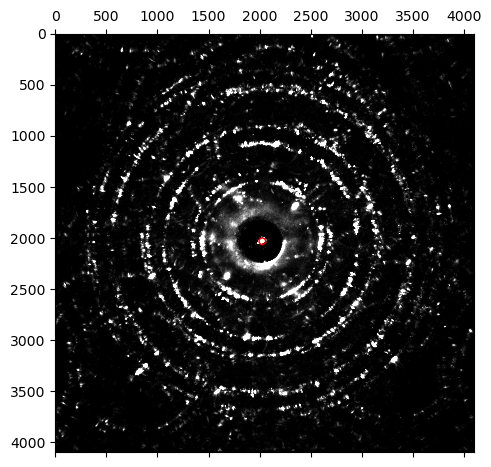

In [191]:
# Now that we've calibrated the center positions, we can re-compute
# the Bragg vector map, this time with the center correction applied

sampling = 8

# compute
bvm = braggpeaks.histogram(
    #mode='cal',             # 'cal' is the default mode, so this line can be included or left out
    sampling = sampling,
)

# show
# overlay a circle around the center for visualization purposes
show(
    bvm,
    circle={
        'center' : bvm.origin,   # the centered BVM knows where its origin is 
        'R' : 4*sampling,
        'fill' : False,
        'linewidth' : 1
    },
    #vmax=0.9
)

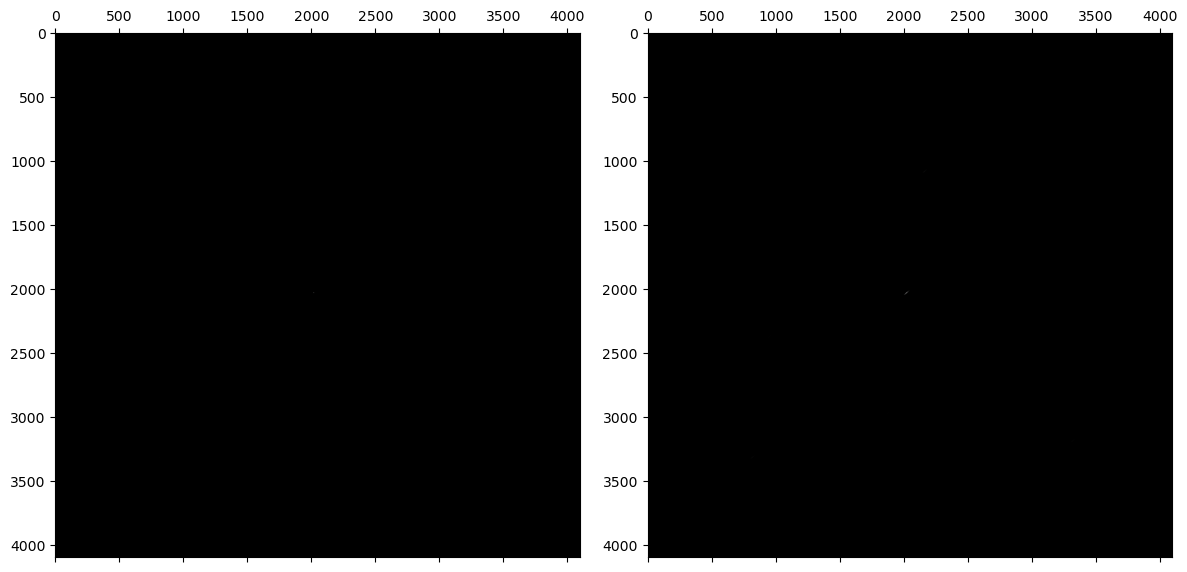

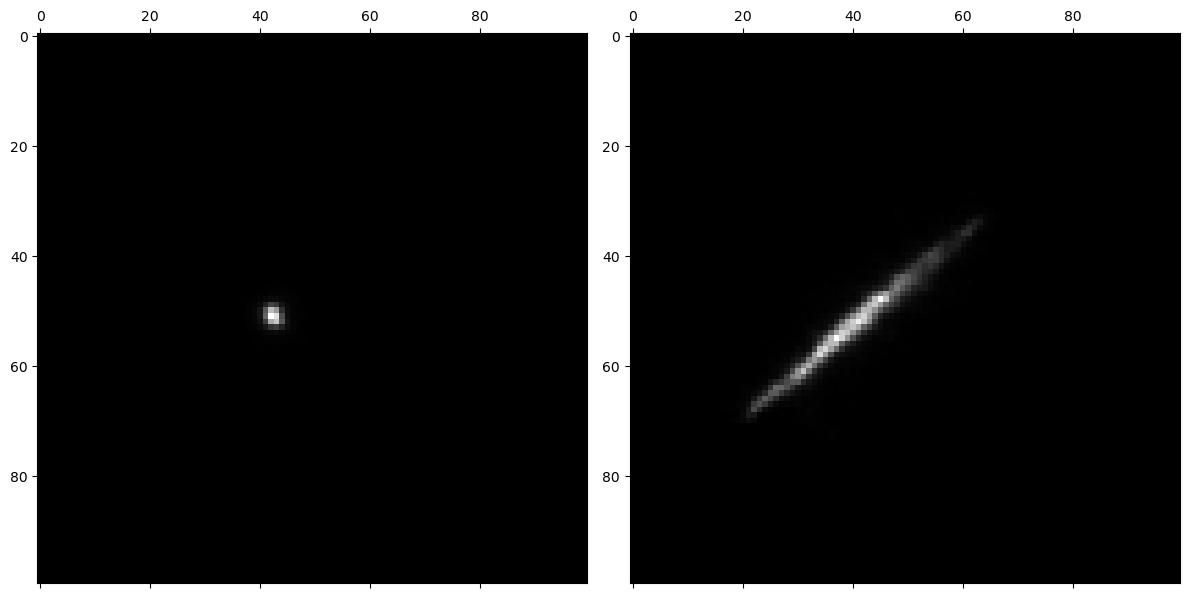

In [192]:
# Compare this to the uncalibrated BVM - much better!

# compute raw vs. centered
bvm_r = braggpeaks.histogram( mode='raw', sampling=sampling )
bvm_c = braggpeaks.histogram( mode='cal', sampling=sampling )

# show
show( [bvm_r, bvm_c] ,vmax=1e5)

# show, zooming in on origin
L = 50
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    vmax=1e5
)

In [193]:
# This output is fun.  What's going on here?

print(bvm_c.pixelsize)
print(bvm_c.pixelunits)

0.0009123965166509152
A^-1


# Calibrate the ellipticity

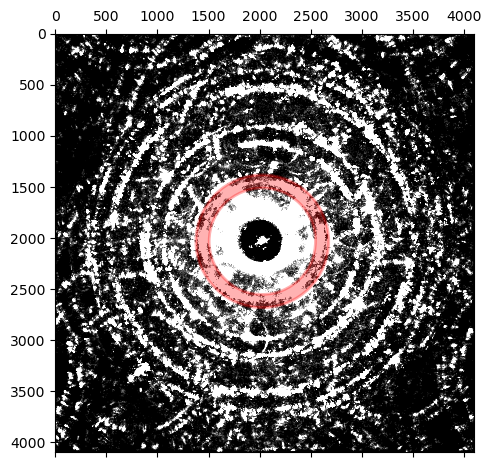

In [194]:
# Select an annular region in which to perform a fit
# The ideal is a single, isolated ring of peaks

#q_range = (310, 384)
q_range = (520, 650)

py4DSTEM.show(
    bvm_c,
    cmap='gray',
    intensity_range='absolute',
    vmin=0,
    vmax=1e2,
    annulus={
        'center':bvm_c.origin,
        'radii': q_range,'fill':True,'color':'r','alpha':0.3}
)

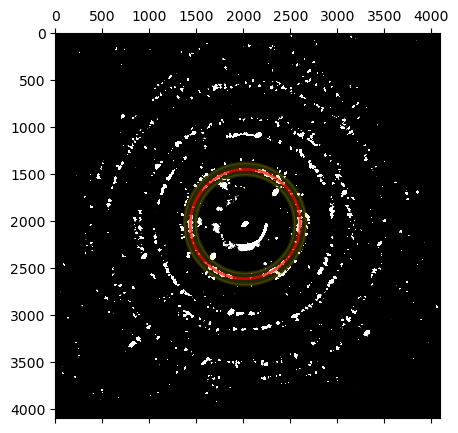

In [195]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_c,
    center = bvm_c.origin,
    fitradii = q_range,
)

# plot the fit
py4DSTEM.visualize.show_elliptical_fit(
    bvm_c,
    q_range,
    p_ellipse,
    cmap='gray',
    intensity_range='absolute',
    vmin=800,
    vmax=1e3,
)

In [196]:
p_ellipse

(2030.6238377301545,
 2021.2007820764206,
 586.6972915499178,
 579.7485386887054,
 -1.094329280203596)

In [197]:
# The elliptical parameters are not automatically added to the calibration metadata,
# (to allow inspection of the fit to ensure it's accurate), so need to be added manually
# once a good fit is found. Like so:

braggpeaks.calibration.set_p_ellipse(p_ellipse)

In [198]:
# Note that the code above only adds (a,b,theta) to the calibration metadata; the origin needs to
# be calibrated separately, as we did above 

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.0072991721332073215
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    9.379479520193339
             qx0_mean:           253.9385904004459
             qy0_mean:           253.29710703002038
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_shift:          2D-array
             a:                  586.6972915499178
             b:                  579.7485386887054
             theta:              -1.094329280203596
)

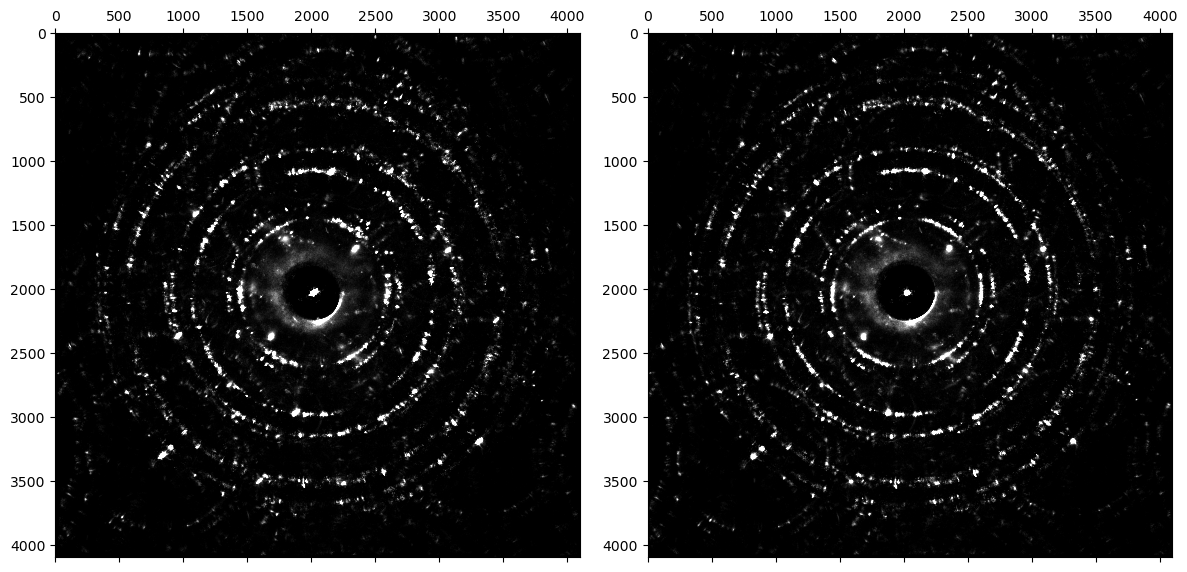

In [199]:
# Calibrate, compute a new bragg vector map, and compare

braggpeaks.setcal()
bvm_e = braggpeaks.histogram(
    sampling=sampling
)

show([bvm_e, bvm_r],vmax=0.99)

# Calibrate the detector pixel size
## Gold
The pixel size should be calibrated from a known standard.  In this case, our data is of Au nanoparticles, so we can use the scattering from the data itself for calibration.  For experiments examining samples of unknown structure, it is best practice is to record a separate scan of a standard sample, such as Au nanoparticles, for each set of microscope conditions used.  Calibration scans should be performed during the same session as the experimental scans.

For data that requires elliptical calibrations, the pixel size should be calibrated last, as prior calibrations like ellipticity will influence the pixel size.  Before calibrating and correcting the ellipticity, the true pixel size was effectively variable by position and direction in diffraction space!

Below, we calibrate the pixel size by computing the structure factors of gold, and matching them to our detected bragg scattering


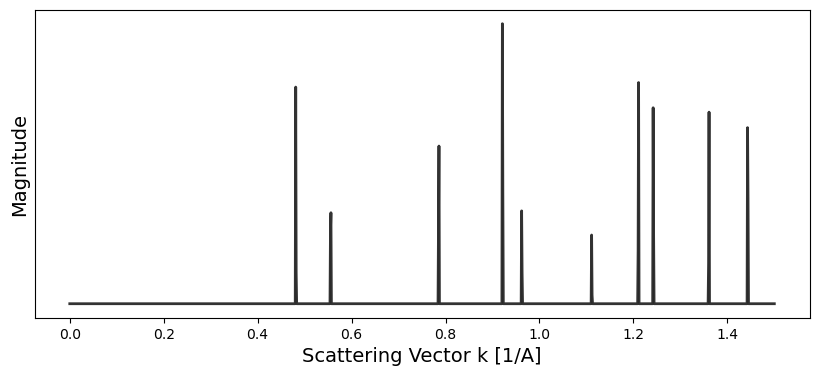

In [200]:
# Define NiCu structure 

# Set lattice parameters for graphite (in Angstroms)
a_lat = 3.6  # a-axis for the hexagonal lattice
atom_num = 28

# Set max scattering angle, in inverse Angstroms
k_max = 1.5

# Define the atomic positions in the FCC lattice
# FCC positions in a cubic cell:
# (0,0,0), (0.5,0.5,0), (0.5,0,0.5), (0,0.5,0.5)
pos = np.array([
    [0.0, 0.0, 0.0],   # Position 1
    [0.5, 0.5, 0.0],   # Position 2
    [0.5, 0.0, 0.5],   # Position 3
    [0.0, 0.5, 0.5],   # Position 4
])

# Make crystal for FCC NiCu alloy
crystal = py4DSTEM.process.diffraction.Crystal(
    pos,
    atom_num,
    a_lat
)

# Calculate structure factors for FCC NiCu alloy
crystal.calculate_structure_factors(k_max)

# Show scattering intensity
crystal.plot_scattering_intensity()


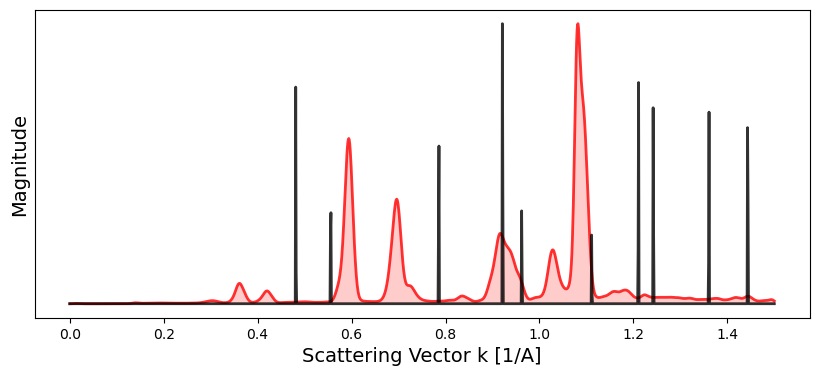

In [218]:
# Make an initial guess at the pixel size to refine
# Let's estimate eith an overlay of the measured scattering and reference crystal structure.


# Modify `pixel_size_inv_Ang_guess` until it 
# looks close before attempting to fit the data!
pixel_size_inv_Ang_guess = 0.005


# calibrate
braggpeaks.calibration.set_Q_pixel_size(pixel_size_inv_Ang_guess)
braggpeaks.calibration.set_Q_pixel_units('A^-1')
braggpeaks.setcal()

# show overlay
crystal.plot_scattering_intensity(
    bragg_peaks = braggpeaks,
    bragg_k_power = 2.0
)

Calibrated pixel size = 0.00403155 A^-1


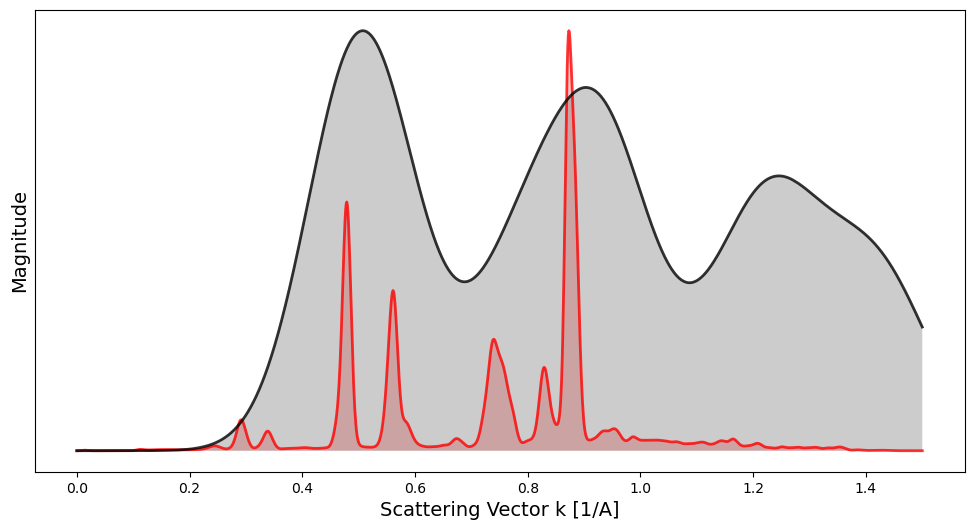

In [219]:
# fit pixel size to lattice

crystal.calibrate_pixel_size(
    bragg_peaks = braggpeaks,
    bragg_k_power = 2.0,
    plot_result = True,
);

In [220]:
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.005
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             probe_semiangle:    9.379479520193339
             qx0_mean:           253.9385904004459
             qy0_mean:           253.29710703002038
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_shift:          2D-array
             a:                  586.6972915499178
             b:                  579.7485386887054
             theta:              -1.094329280203596
)

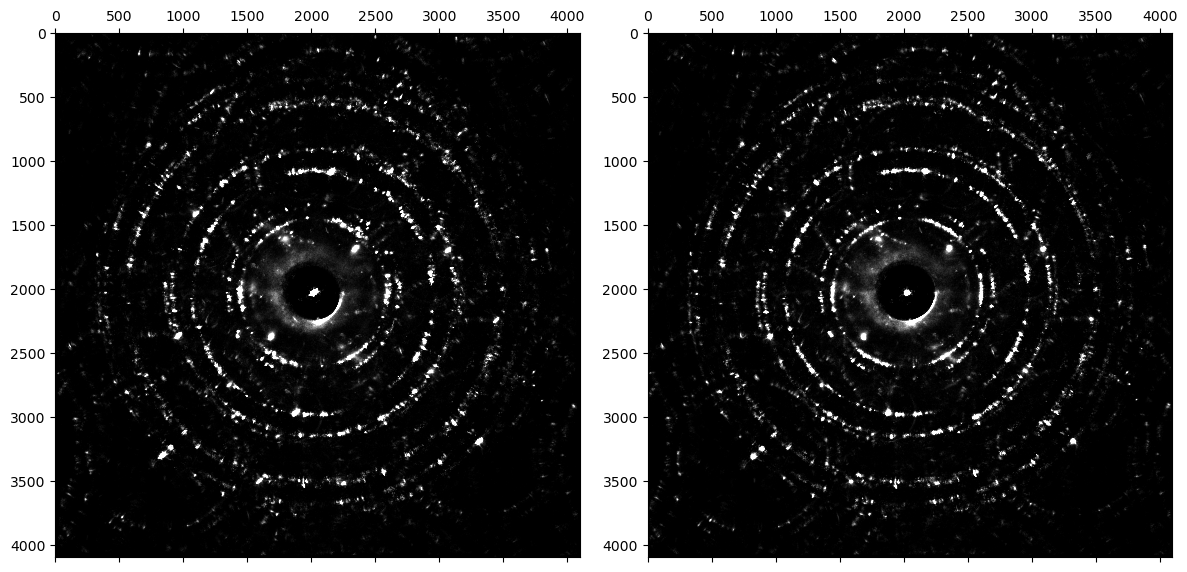

In [221]:
# New bvm, compare

braggpeaks.setcal()
bvm_p = braggpeaks.histogram(
    sampling=sampling
)

show([bvm_p, bvm_r],vmax=0.99)

In [222]:
bvm_p

BraggVectorMap( A 2-dimensional array of shape (4096, 4096) called '2Dhist_braggvectors_cal_s=8',
                with dimensions:

                    dim0 = [-1.2696929520022295,-1.2690679520022294,-1.2684429520022296,...] A^-1  (*non-linear*)
                    dim1 = [-1.2664855351501019,-1.265860535150102,-1.265235535150102,...] A^-1  (*non-linear*)
)

# Write and read

In [223]:
# set a filepath

filepath_basics_03 = dirpath + 'analysis_basics_03.h5'
filepath_basics_03

'/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/analysis_basics_03.h5'

In [224]:
# inspect what's in the data tree

basics_02.tree()

/
|---braggvectors
|---probe


In [225]:
# we can see above that the bragg vector map doesn't get added automatically to the tree.
# just for fun, let's do that now:

basics_02.tree(
    bvm_p
)

basics_02.tree()

/
|---braggvectors
|---probe
|---2Dhist_braggvectors_cal_s=8


In [226]:
# save

py4DSTEM.save(
    filepath_basics_03,
    basics_02,
    tree=None,
    mode = 'o'
)

100%|███████████████████████████████████████████████████████████| 33108/33108 [00:03<00:00, 8905.45it/s]


In [227]:
# inspect the resulting HDF5 file

py4DSTEM.print_h5_tree(filepath_basics_03)

/
|---dm_dataset_root
    |---2Dhist_braggvectors_cal_s=8
    |---braggvectors
    |   |---_v_uncal
    |---probe




In [228]:
# read

d = py4DSTEM.read(
    filepath_basics_03,
)

Reading PointListArray: 100%|████████████████████████████| 33108/33108 [00:05<00:00, 5853.62PointList/s]


In [229]:
d.tree()

/
|---2Dhist_braggvectors_cal_s=8
|---braggvectors
|---probe


In [230]:
d.tree('braggvectors')

BraggVectors( A (186, 178)-shaped array of lists of bragg vectors )

In [231]:
# check that all the calibrations loaded correctly

d.tree('braggvectors').calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.005
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             a:                  586.6972915499178
             b:                  579.7485386887054
             origin_meas_mask:   2D-array
             probe_semiangle:    9.379479520193339
             qx0:                2D-array
             qx0_mean:           253.9385904004459
             qx0_meas:           2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           253.29710703002038
             qy0_meas:           2D-array
             qy0_shift:          2D-array
             theta:              -1.094329280203596
)